# <span style = "color:green;">**ASTR-19 Final Project**</span> (Part 2)

### *Hubble Ultra Deep Field image*

#### Following the sep tutorial:

In [1]:
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

rcParams['figure.figsize'] = [10, 8] 

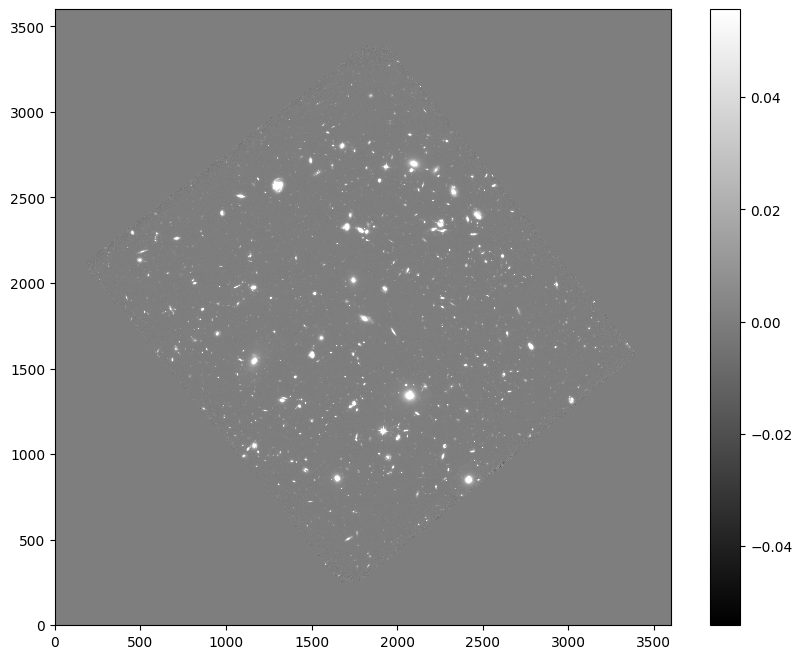

In [2]:
data = fits.getdata('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')

m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation = 'nearest', cmap = 'gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

plt.savefig('udf_f105w.png')

In [3]:
data = data.byteswap(inplace=True).newbyteorder()

In [4]:
bkg = sep.Background(data)

print('Global Back =', bkg.globalback)
print('Global RMS =', bkg.globalrms)

Global Back = 0.0
Global RMS = 0.0005398219218477607


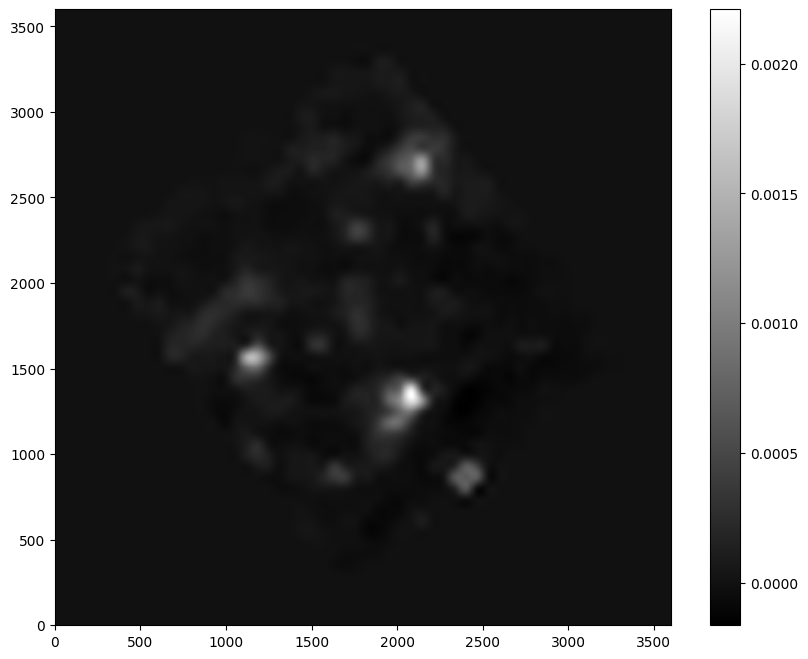

In [5]:
bkg_image = np.array(bkg)

plt.imshow(bkg_image, interpolation = 'nearest', cmap = 'gray', origin = 'lower')
plt.colorbar();

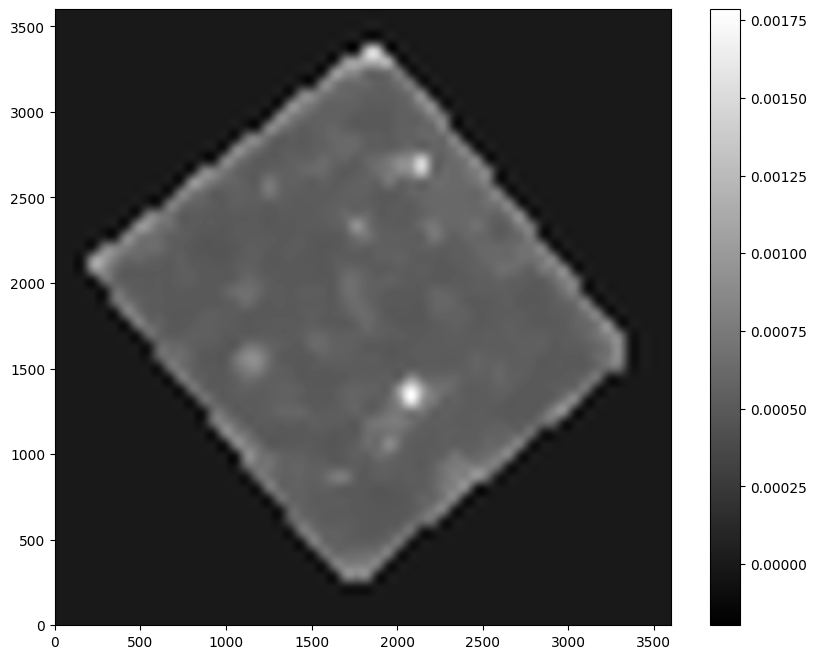

In [6]:
bkg_rms = bkg.rms()

plt.imshow(bkg_rms, interpolation = "nearest", cmap = 'gray', origin = 'lower')
plt.colorbar();

In [7]:
data_sub = data - bkg

objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
print('Number of sources:', len(objects))

Number of sources: 8640


In [8]:
from matplotlib.patches import Ellipse

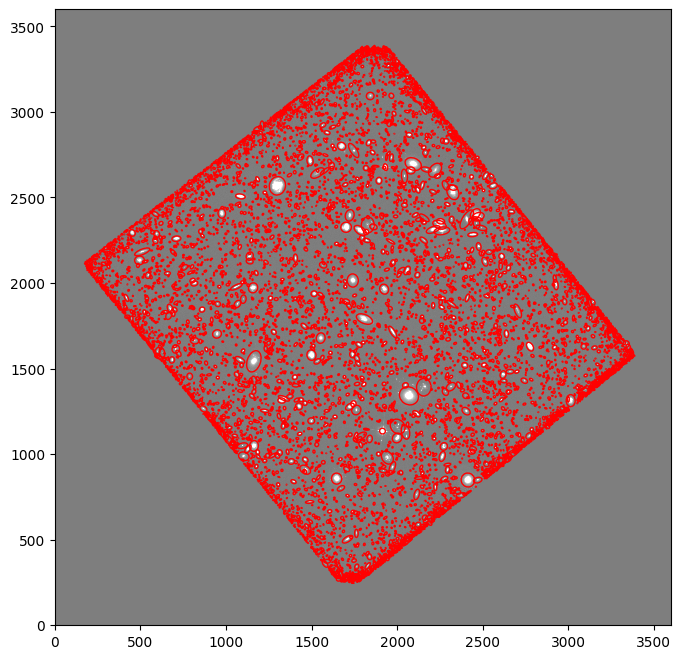

In [9]:
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

for i in range (len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width = 6*objects['a'][i],
                height = 6*objects['b'][i],
                angle = objects['theta'][i] * 180.0 / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

### Histogram the fluxes:

In [10]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err = bkg.globalrms, gain = 1)

#for i in range(8640):
    #print('{:f}'.format(flux[i]))

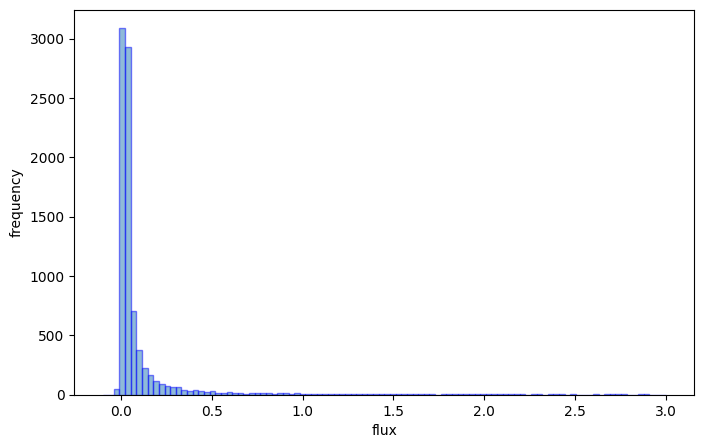

In [11]:
f, ax = plt.subplots(1, 1, figsize=(8,5))
ax.hist(flux, 
        bins = 100, 
        range = (-0.1, 3.0), 
        alpha = 0.5, 
        edgecolor = 'blue')
ax.set_xlabel('flux')
ax.set_ylabel('frequency');

### Max, Min, Mean, Median, and Standard Deviation of Flux:

In [12]:
max = max(flux)
min = min(flux)
median_flux = np.median(flux)
mean_flux = np.mean(flux)
std_flux = np.std(flux)

print('Maximum Flux:', "{:.6f}".format(max), '\nMinimum Flux:', "{:.6f}".format(min), '\nMedian Flux:', "{:.6f}".format(median_flux), '\nMean Flux:', "{:.6f}".format(mean_flux), '\nFlux Standard Deviation:', "{:.6f}".format(std_flux))  

Maximum Flux: 807.297284 
Minimum Flux: -1.061365 
Median Flux: 0.030957 
Mean Flux: 0.361862 
Flux Standard Deviation: 9.243528


### Outliers
##### Maximum Outlier, its standard deviation, and location:

In [13]:
outliers = np.abs(flux - mean_flux)
max_outlier_index = np.argmax(outliers)
max_outlier_flux = flux[max_outlier_index]
max_outlier_std = outliers[max_outlier_index] / std_flux

location_max_x = (objects['x'][max_outlier_index])
location_max_y = (objects['y'][max_outlier_index])

print(f"Max Outlier Flux: {max_outlier_flux:.6f}, \nStandard Deviation of Max Outlier: {max_outlier_std:.6f}")
print(f"Location of Max Outlier: ({location_max_x:.6f}, {location_max_y:.6f})")

Max Outlier Flux: 807.297284, 
Standard Deviation of Max Outlier: 87.297343
Location of Max Outlier: (1914.254909, 1134.316485)


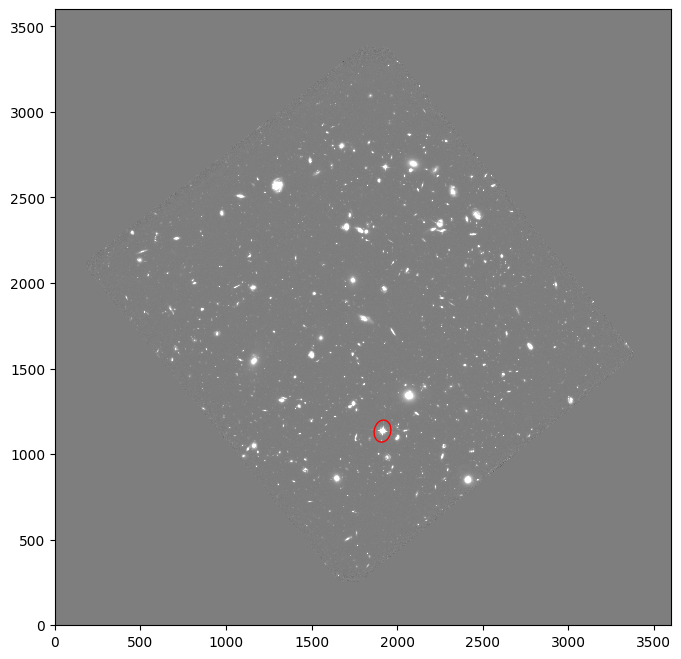

In [14]:
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

max_e = Ellipse(xy=(location_max_x, location_max_y),
                width = 150*objects['a'][i],
                height = 150*objects['b'][i],
                angle = objects['theta'][i] * 180.0 / np.pi)
max_e.set_facecolor('none')
max_e.set_edgecolor('red')
ax.add_artist(max_e);

### Creating a 3-color false image of the UDF:

In [15]:
f105w = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
f125w = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
f160w = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"

hdu105w = fits.open(f105w)
hdu125w = fits.open(f125w)
hdu160w = fits.open(f160w)

data105w = hdu105w[0].data
data125w = hdu125w[0].data
data160w = hdu160w[0].data

In [16]:
def rescale_image(data):
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m/2
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m * 100)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp, vpmin, vpmax

In [17]:
# use rescaled images
res_105w, d105min, d105max = rescale_image(data105w)
res_125w, d125min, d125max = rescale_image(data125w)
res_160w, d160min, d160max = rescale_image(data160w)

In [18]:
# set data to be between min and max rescaling values
res_105w[res_105w < d105min] = d105min
res_105w[res_105w > d105max] = d105max

res_125w[res_125w < d125min] = d125min
res_125w[res_125w > d125max] = d125max

res_160w[res_160w < d160min] = d160min
res_160w[res_160w > d160max] = d160max

In [19]:
rgb = np.zeros((data105w.shape[0], data105w.shape[1],3))

rgb[:,:,0] = (res_105w - d105min)/(d105max - d105min)
rgb[:,:,1] = (res_125w - d125min)/(d125max - d125min)
rgb[:,:,2] = (res_160w - d160min)/(d160max - d160min)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


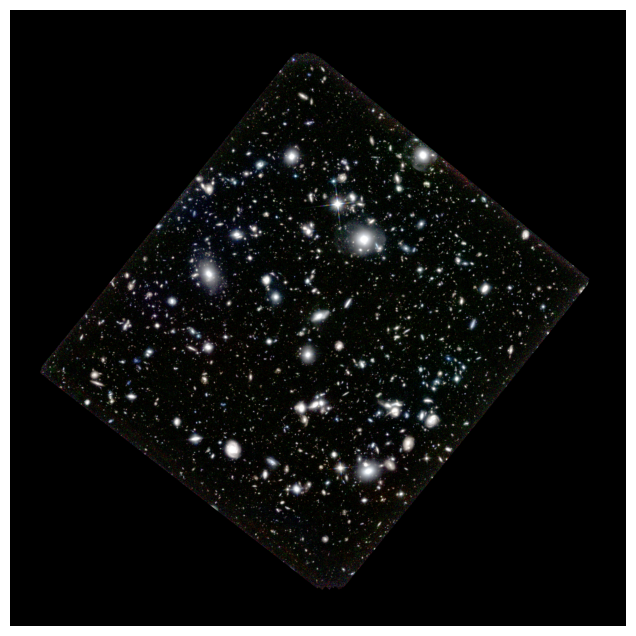

In [20]:
f, ax = plt.subplots(1,1)
ax.axis('off')
ax.imshow(rgb)
plt.savefig('UDF_3color_image.png', bbox_inches='tight', pad_inches = 0, dpi=600);